In [80]:
import numdifftools as nd
from math import pi, exp, sqrt, log
from numpy.linalg import det, slogdet
from numpy import array, linspace, logspace
import matplotlib.pyplot as plt
%matplotlib inline 

### Ideal free energy contribution
This is comprised of the large colloids (or polyions), the polymer and the two monovalent ions. The form I use below is technically incorrect as the density has dimensions and I apply a log to it. This is irrelevant though as any arbitrary constant volume multiplicative factor can be introduced in the log without penalty. Upon taking a derivative with repect to density, one would find this term cancels itself. This is the same as saying the free energy is totally arbitrary to within a constant additive factor

---

In [155]:
def Aid(p_c, p_p, #state variables
        d_c, d_p  #system variables
       ):
    
    #just creating an arbitrary length scale to non-dimensionalize the log term
    vol = (d_c/2.0 + d_p/2.0)**3.0
    p = p_c + p_p
    
    #ideal contribution containing both mixing and translational entropy
    a_id = p_c*log(p_c*vol) + p_p*log(p_p*vol) - p
    
    return a_id

###   Contribution of the non-addittive AO model to the free energy.
This uses the approximate equation of state of Woodward et al. I use this as apposed to the Santos theory as it is simpler and yields similar results to the free volume form which agrees well with Santos.

---

In [156]:
def Aao(p_c, p_p, #state variables
        d_c, d_p  #system parameters
       ):
    
    #calculate volume fraction
    n_c = (pi/6.0)*(d_c**3.0)*p_c
    
    #ratio
    q = d_p/d_c
    
    #some parameters
    A = 3.0*q + 3.0*(q**2.0) + q**3.0
    B = (9.0/2.0)*(q**2.0) + 3.0*(q**3.0)
    C = 3.0*(q**3.0)
    w = -log(1.0 - n_c) + A*(n_c/(1.0 - n_c)) + B*((n_c/(1.0 - n_c))**2.0) + C*((n_c/(1.0 - n_c))**3.0)
    
    #free volume theory free energy
    a_hs_ref = p_c*(-3.0 + 2.0/(1.0 - n_c) + 1.0/((1.0 - n_c)**2.0)) 
    a_fv_pert = p_p*w
    
    #total free energy
    a_ao = a_hs_ref + a_fv_pert
    
    return a_ao   

###   Bonding contribution to the free energy.
This uses Werthiem theory combined with an approximation for the colloid-polymer contact value in the AO model

---

Using the Santos theory for AO contact value (J. Chem. Phys. 122, 024514 2005)

In [286]:
def Gcp(p_c, p_p,  #state variables
        d_c, d_p   #system parameters
       ):
    
    #colloid volume fraction and non-additive AO weight for contact formula
    n_c = (pi/6.0)*(d_c**3.0)*p_c
    z_cp = (2.0*d_p/d_c)/(1.0 + d_p/d_c)
    
    #pure contact value
    g_c_pure = (1.0 - n_c/2.0)/((1.0 - n_c)**3.0)
    
    #cross contact value based on the Santos approximation
    g_cp = (1.0/(1.0 - n_c)) + z_cp*(g_c_pure - (1.0/(1.0 - n_c)))
    
    return g_cp

The fraction of bonded species based on analytically solving the Werthiem equations

In [158]:
def X(p_c, p_p, T,               #state variables
       d_c, d_p, m_c, m_p, v_cp  #system parameters
      ):
    
    #make sure patch number is a float just in case
    m_c = float(m_c)
    m_p = float(m_p)
    
    #this is different from the usual definition as it does not explicitly contain the contact value
    delta = v_cp*(exp(1.0/T) - 1.0);
    
    #total density
    p = p_c + p_p
    
    #species fractions
    f_c = p_c/p
    f_p = p_p/p
    
    #analytical formula for X_c and X_p
    X_c = 2.0 / (1.0 + delta*m_p*p*Gcp(p_c, p_p, d_c, d_p) - delta*f_c*(m_c + m_p)*p*Gcp(p_c, p_p, d_c, d_p) + sqrt(4.0*delta*f_c*m_c*p*Gcp(p_c, p_p, d_c, d_p) + pow(-1.0 + delta*(-m_p + f_c*(m_c + m_p))*p*Gcp(p_c, p_p, d_c, d_p), 2.0)))
    X_p = 2.0 / (1.0 - delta*m_p*p*Gcp(p_c, p_p, d_c, d_p) + delta*f_c*(m_c + m_p)*p*Gcp(p_c, p_p, d_c, d_p) + sqrt(4.0*delta*f_c*m_c*p*Gcp(p_c, p_p, d_c, d_p) + pow(-1.0 + delta*(-m_p + f_c*(m_c + m_p))*p*Gcp(p_c, p_p, d_c, d_p), 2.0)))
    
    return (X_c, X_p)

Werthiem free energy change due to bonding

In [159]:
def Abd(p_c, p_p, T,              #state variables
       d_c, d_p, m_c, m_p, v_cp  #system parameters
       ):
    
    #make sure patch number is a float just in case
    m_c = float(m_c)
    m_p = float(m_p)
    
    #bonded fraction of each species
    X_c, X_p = X(p_c, p_p, T,
                 d_c, d_p, m_c, m_p, v_cp)
    
    #excess bonding free energy
    a_bd = p_c*(m_c*log(X_c) - m_c*X_c/2.0 + m_c/2.0) + p_p*(m_p*log(X_p) - m_p*X_p/2.0 + m_p/2.0)
    
    return a_bd

###   Total free energy

---

In [160]:
def A(p_c, p_p, T,              #state variables
      d_c, d_p, m_c, m_p, v_cp  #system parameters
     ):
    
    #make sure patch number is a float just in case
    m_c = float(m_c)
    m_p = float(m_p)
    
    #get the various contributions
    a_id = Aid(p_c, p_p, d_c, d_p)
    a_ao = Aao(p_c, p_p, d_c, d_p)
    a_bd = Abd(p_c, p_p, T, d_c, d_p, m_c, m_p, v_cp)
    
    #the total free energy
    a = a_id + a_ao + a_bd
    
    return a

###   Stabilility calculation
Here we calculate the stability limits of the system via a standard spinodal calculation. For the helmholts free energy we only need to look at any determnant that contains n-1 degrees of freedom where n counts all the extensive variables.

---

In [161]:
def DA(p_c, p_p, T,              #state variables
       d_c, d_p, m_c, m_p, v_cp, #system parameters
       min_step                  #minimum step to use for hessian calculation
      ):
    
    #generate steps for calculating hessian
    hess_steps = nd.MinStepGenerator(base_step=min_step, step_ratio=2.0, num_steps = 2)
    
    #calculate the hessian (stability matrix)
    calculate_hessian = lambda x: A(x[0], x[1], T, d_c, d_p, m_c, m_p, v_cp)
    stability_matrix = nd.Hessian(calculate_hessian, step = hess_steps)([p_c, p_p])
    
    #build the 3x3 (or 2x2) stability matrix as a numpy array and calculate the determinant 
    #logdet is used to avoid issues with a small determinant (such as when an instability is reached)
    (sign, logdet) = slogdet(stability_matrix)
    stability_determinant = sign*exp(logdet)    
        
    #return the stability determinant
    return stability_determinant

Performs a grid search and labels points as stable or unstable

In [164]:
#performs grid search and labels each point as stable or unstable
def CalculateSpinodal(p_c_vals, g_pc_vals,          #state variables for grid search
                      T,                            #intensive state variables held fixed
                      d_c, d_p, m_c, m_p, v_cp,     #system variables
                      min_step                      #minimum step to use for hessian calculation
                     ):
    
    #lists for storing the grid points classified as stable and unstable 
    stable = [[],[],[],[],[]]
    unstable = [[],[],[],[],[]]
    
    #sample the grid points
    for p_c in p_c_vals:
        for g_pc in g_pc_vals:
            p_p = g_pc*p_c
            D_A = DA(p_c, p_p, T, d_c, d_p, m_c, m_p, v_cp, min_step)
            if D_A < 0.0:
                unstable[0].append(p_c)
                unstable[1].append(p_p)
                unstable[2].append(p_p/p_c)
                unstable[3].append(((pi/6.0)*d_c*d_c*d_c)*p_c)
                unstable[4].append(((pi/6.0)*d_p*d_p*d_p)*p_p)
            else:
                stable[0].append(p_c)
                stable[1].append(p_p)
                stable[2].append(p_p/p_c)
                stable[3].append(((pi/6.0)*d_c*d_c*d_c)*p_c)
                stable[4].append(((pi/6.0)*d_p*d_p*d_p)*p_p)
    
    return (stable, unstable)

###   Calculate phase diagrams
Using our free energy based theory we can calculate stability based phase diagrams

---

In [284]:
#system variables
d_c = 1.0
d_p = 1.1/3.68
m_c = 45
m_p = 1.8  #2.0
v_cp = 1.0

#state variables
T=13.0  #17.0


#colloid
n_c_vals = linspace(0.004, 0.4, num=100)
#polymer
g_pc_vals = logspace(-1, 3.7, num=100)

#recalculate in terms of densities
p_c_vals = 6.0*n_c_vals/(pi*d_c*d_c*d_c)

min_step= 0.0001 #0.001
stable, unstable = CalculateSpinodal(p_c_vals, g_pc_vals, T, d_c, d_p, m_c, m_p, v_cp, min_step)

In [253]:
#system variables
d_c = 1.0
d_p = 1.1/3.68
m_c = 25
m_p = 3
v_cp = 1.0

#state variables
T=9.0


#colloid
n_c_vals = linspace(0.004, 0.4, num=100)
#polymer
g_pc_vals = logspace(-1, 3.7, num=100)

#recalculate in terms of densities
p_c_vals = 6.0*n_c_vals/(pi*d_c*d_c*d_c)

min_step= 0.0001 #0.001
stable, unstable = CalculateSpinodal(p_c_vals, g_pc_vals, T, d_c, d_p, m_c, m_p, v_cp, min_step)

In [273]:
#system variables
d_c = 1.0
d_p = 1.1/3.68
m_c = 25
m_p = 6
v_cp = 1.0

#state variables
T=40.0


#colloid
n_c_vals = linspace(0.004, 0.4, num=100)
#polymer
g_pc_vals = logspace(-1, 3.7, num=100)

#recalculate in terms of densities
p_c_vals = 6.0*n_c_vals/(pi*d_c*d_c*d_c)

min_step= 0.0001 #0.001
stable, unstable = CalculateSpinodal(p_c_vals, g_pc_vals, T, d_c, d_p, m_c, m_p, v_cp, min_step)

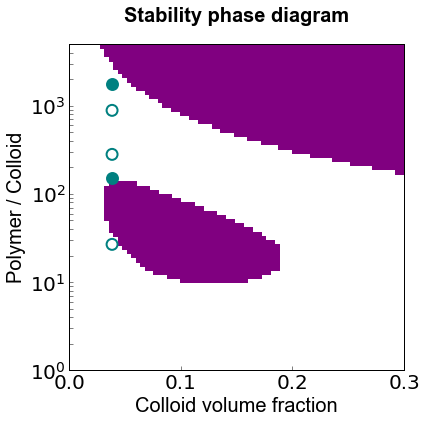

In [285]:
#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


plt.xlabel('Colloid volume fraction', fontsize=20, fontdict = axis_label_font)
plt.ylabel('Polymer / Colloid', fontsize=20, fontdict = axis_label_font)
plt.scatter(stable[3], stable[2], c="w", marker="s", s=120, alpha=1.0, linewidths=0.0)
plt.scatter(unstable[3],unstable[2], c="purple", marker="s", s=120, alpha=1.0, linewidths=0.0)
plt.scatter([0.0384, 0.0384, 0.0384], [26.8, 281, 887], c="none", linestyle = '-', linewidth = 2, edgecolor="teal", s=120.0)
plt.scatter([0.0384, 0.0384], [150, 1747], c="teal", linestyle = '-', linewidth = 2, edgecolor="teal", s=120.0)
plt.ylim((1,5000))
plt.yscale('log')
plt.xlim((0,0.3))

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title("Stability phase diagram", y=1.05, fontdict = title_font)

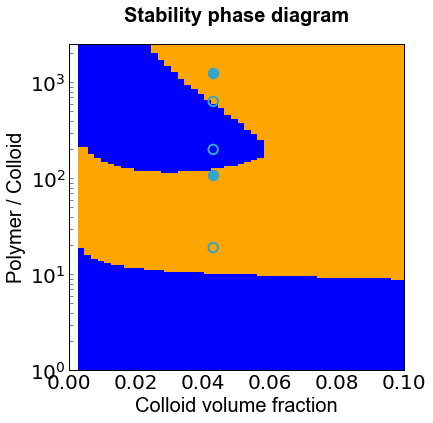

In [119]:
#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


plt.xlabel('Colloid volume fraction', fontsize=20, fontdict = axis_label_font)
plt.ylabel('Polymer / Colloid', fontsize=20, fontdict = axis_label_font)
plt.scatter(stable[3], stable[2], c="b", marker="s", s=120, alpha=1.0, linewidths=0.0)
plt.scatter(unstable[3],unstable[2], c="orange", marker="s", s=120, alpha=1.0, linewidths=0.0)
plt.scatter([0.043, 0.043, 0.043], [19, 200, 633], c="none", linestyle = '-', linewidth = 2, edgecolor="#33a6cc", s=90.0)
plt.scatter([0.043, 0.043], [108, 1247], c="#33a6cc", linestyle = '-', linewidth = 2, edgecolor="#33a6cc", s=90.0)
plt.ylim((1,2500))
plt.yscale('log')
plt.xlim((0,0.1))

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title("Stability phase diagram", y=1.05, fontdict = title_font)

In [289]:
#system variables
d_c = 1.0
d_p = 0.33 ############0.45
m_c = 6
m_p = 2
v_cp = 1.0

#state variables
n_c = 0.03 #0.005
n_p = 8.00
T=10.5

#recalculate in terms of densities
p_c = 6.0*n_c/(pi*d_c*d_c*d_c)
p_p = 6.0*n_p/(pi*d_p*d_p*d_p)

In [290]:
X_c, X_p = X(p_c, p_p, T, d_c, d_p, m_c, m_p, v_cp)
print "X_c = {0}".format(X_c)
print "X_p = {0}".format(X_p)

X_c = 0.0116373698764
X_p = 0.999600413637


In [42]:
Gcp(p_c, p_p, d_c, d_p)

1.0549059855241865

In [287]:
#system variables
d_c = 0.33
d_p = 1.00 ############0.45
m_c = 2
m_p = 6
v_cp = 1.0

#state variables
n_c = 8.00 #0.005
n_p = 0.03
T=10.5

#recalculate in terms of densities
p_c = 6.0*n_c/(pi*d_c*d_c*d_c)
p_p = 6.0*n_p/(pi*d_p*d_p*d_p)

In [288]:
X_c, X_p = X(p_c, p_p, T, d_c, d_p, m_c, m_p, v_cp)
print "X_c = {0}".format(X_c)
print "X_p = {0}".format(X_p)

X_c = 0.999600413637
X_p = 0.0116373698764


In [45]:
Gcp(p_c, p_p, d_c, d_p)

0.08511804292071284